In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
import time

### Read Dataset

In [2]:
play = pd.read_csv('/home/pv70249/LSH_DataSets/10kusers_500songs.csv', sep=',')
play.columns=['user','song','listen_count']

In [3]:
print ("Users-Songs: ", play['user'].count())
print ("Unique Users: ", play['user'].nunique())
print ("Unique Songs: ", play['song'].nunique())

Users-Songs:  357505
Unique Users:  9943
Unique Songs:  500


### Create Training and Testing Datasets

In [4]:
def split_data_train_test_random(self, train_proportion, test_proportion, random_state=42):
    df_train, df_test = train_test_split(self, train_size=train_proportion,
                                         test_size=test_proportion, random_state=42)
    return df_train, df_test


train_set,test_set = split_data_train_test_random(play,.8,.2)

In [5]:
print ( "Training:", "user-song pairs -", train_set['user'].count(), "unique users -", train_set['user'].nunique() ,"unique songs -", train_set['song'].nunique())
print ( "Testing :", "user-song pairs -", test_set['user'].count(), "unique users -", test_set['user'].nunique() ,"unique songs -", test_set['song'].nunique())

Training: user-song pairs - 286004 unique users - 9912 unique songs - 500
Testing : user-song pairs - 71501 unique users - 9221 unique songs - 500


In [6]:
users = train_set['user'].unique()
songs = train_set['song'].unique()

songs_dict  = dict(zip(songs, range(len(songs))))
users_dict = dict(zip(users, range(len(users))))

data = np.zeros((train_set['user'].nunique(),train_set['song'].nunique()))
for index,row in train_set.iterrows():
    data[users_dict[row['user']], songs_dict[row['song']]] = row['listen_count']


### Baseline prediction count calculation

In [7]:
def baseline_prediction(df):
    baseline = df['listen_count'].mean()
    return baseline

baseline = baseline_prediction(train_set)
print (baseline)

2.612634788324639


In [8]:
play_matrix = play.pivot(index='song', columns='user', values='listen_count')
play_matrix = play_matrix.fillna(0)
training_matrix = train_set.pivot(index='song', columns='user', values='listen_count')
training_matrix = training_matrix.fillna(0)


### The below Code create the hash functions, hash buckets and calculates similar items

In [9]:
def create_hash_functions(data, r):
    # Create Hash Functions
    # Inputs: (song,user) matrix; r - number of hash function for each band
    # Output = return the r hash functions
    
    rows,cols = data.shape
    hash_functions = np.random.standard_normal(size=(cols,r))
    return hash_functions

def create_hash_buckets(data, hash_functions, r):
    # Inputs: (song, user) matrix, the has functions created earlier
    # Ouput: Create a dictionary of hash values and the correponding matching song indices.
    # Generate a signature matrix from the hash functions and map it to the hash value to collect similar items
    
    hash_signatures = np.dot(data,hash_functions) >= 0    
    func_arr = 2 ** np.array(range(r -1 ,-1,-1))
    hash_value = np.dot(hash_signatures,func_arr)
    
    dict_hash = {}
    
    for i in range(len(hash_value)):
        if hash_value[i] not in dict_hash:
            dict_hash[hash_value[i]] = list()
        dict_hash[hash_value[i]].append(i)
        
    return dict_hash


def create_hash_tables(data, r, b):
    #Input: data - (song,user) matrix
    # r - number of hash functions in each band
    # b - number of hash buckets
    
    rows, cols = data.shape
    l_dict_hash = []
    l_hash_functions = []
    for i in range(b):
        h_functions = create_hash_functions(data, r)
        h_dict = create_hash_buckets(data, h_functions, r)
        l_dict_hash.append(h_dict)
        l_hash_functions.append(h_functions)
    return l_hash_functions, l_dict_hash


def similar_items(data, idx, l_hash_functions, l_dict_hash, r , b  ):
    # Input - index of the song
    # Output - list of songs and corresponding similarity distance metric for the given song
    # This returns the similar songs for a given song based on it's hash value.
    
    func_arr = 2 ** np.array(range(r -1 ,-1,-1))
    sim_items = set()
    for i in range(b):
        hash_signatures = np.dot(data[idx,:],l_hash_functions[i]) >= 0
        hash_val = np.dot(hash_signatures,func_arr)
        
        if hash_val in l_dict_hash[i]:
            sim_items.update(l_dict_hash[i][hash_val])

    sim_items.remove(idx)
    
    sim_ndarray = data[np.array(list(sim_items)), :]
    sims = cosine_similarity(csr_matrix(sim_ndarray), csr_matrix(data[idx,:].reshape(1,-1)))[:,0]
#     sims = pairwise_distances(csr_matrix(sim_ndarray), csr_matrix(data[idx,:].reshape(1,-1)), 'euclidean')[:,0]
#     sims = 1/(1+sims)    
    
    return list(zip(list(sim_items), sims))    

def all_similar_items(data, idx ):
    # Input - index of the song
    # data - song,user matrix
    # Output - list of songs and corresponding similarity distance metric for the given song
    # This returns the similar songs for a given song based on it's hash value.
    
    sim_items = set()
    for i in range(data.shape[0]):
        sim_items.update([i])

    sim_items.remove(idx)
#     print sim_items
    
    sim_ndarray = data[np.array(list(sim_items)), :]
    sims = cosine_similarity(csr_matrix(sim_ndarray), csr_matrix(data[idx,:].reshape(1,-1)))[:,0]
#     sims = pairwise_distances(csr_matrix(sim_ndarray), csr_matrix(data[idx,:].reshape(1,-1)), 'euclidean')[:,0]
#     sims = 1/(1+sims)    
    
    return list(zip(list(sim_items), sims))    

### Code to predict individual user-song listen count, Top N songs for a given user

In [10]:
def songs_sim_matrix_rb(songs_rb, data):
    # Inputs: Similarity metrics of list with a bunch of tuples; data of the shape (songs, users)
    # outout: Similarity matrix.
    
    sim_songs_matrix_rb = np.zeros((data.shape[0],data.shape[0]))
    
    for i in range(data.shape[0]):
        for j in range(len(songs_rb[i])):
            sim_songs_matrix_rb[i][songs_rb[i][j][0]] = songs_rb[i][j][1]
            
    return sim_songs_matrix_rb


def predict_individual(song_sim_matrix,data, user_idx, song_idx, baseline, K):
    # song similar matrix : item-item matrix with similarity measures
    # data : user,song matrix
    # user_idx : index of the user for prediction
    # song_idx : index of the song for prediction
    # returns prediction    
    user_items = data[user_idx].nonzero()[0]
    if len(user_items) == 0:
        return baseline
    
    neighbors = user_items[song_sim_matrix[song_idx, user_items].argsort()[::-1][0:K]]
    
    pred = (data[user_idx,neighbors].dot(song_sim_matrix[song_idx,neighbors])/sum(song_sim_matrix[song_idx,neighbors]))
    
    if np.isnan(pred):
        pred = baseline
    return pred

def predict_user_topNsongs(data,user_id,song_sim_matrix, K, N, users_dict,songs_dict,baseline, already_listened=False):
    # data - user,song matrix
    # User ID for prediction
    # song Similarity matrix
    # K - for neighbors
    # N - for prediction to the user.
    # users_dict = dictionary to convert user Id to index.
    # songs_dict - dictionary to convert sond id to index.
    
    n = song_sim_matrix.shape[0]
    
    try:
        user_idx = users_dict[user_id]
    except:
        raise "Application ERROR: User Not Found"         
    
    inverse_songs_dict = dict(zip(songs_dict.values(), songs_dict.keys()))
    listened_items = data[user_idx].nonzero()[0]
    
    temp = []
    for i in range(len(listened_items)):
        temp.append(listened_items[i])
    
    preds = {}
    listened = {}
    
    for j in range(n):
        preds[j] = predict_individual(song_sim_matrix,data,user_idx,j,baseline,K)
    
    for k in listened_items:
#         listened[k] = data[user_idx,k]
        listened[k] = preds[k]
        if not already_listened:
            del preds[k]
            
    sort_listened = sorted(listened.items(), key=lambda x: x[1], reverse = True)
    sort_pred = sorted(preds.items(), key=lambda x: x[1], reverse = True)

    top_recommendation = [inverse_songs_dict[i[0]] for i in sort_pred[:N]]
    top_listened = [inverse_songs_dict[i[0]] for i in sort_listened[:N]]
    
    
    df_pred = pd.DataFrame({ 'pred' : [sort_pred[i][1] for i in range(len(sort_pred))] ,
                            'song_id' : [inverse_songs_dict[i[0]] for i in sort_pred[:]], 
                            'song_idx' : [sort_pred[i][0] for i in range(len(sort_pred))] 
                           })

    df_listened = pd.DataFrame({ 'pred' : [sort_listened[i][1] for i in range(len(sort_listened))] ,
                            'song_id' : [inverse_songs_dict[i[0]] for i in sort_listened[:]], 
                            'song_idx' : [sort_listened[i][0] for i in range(len(sort_listened))] ,
                            'listen_count' : [data[user_idx,i[0]] for i in sort_listened[:]]
                           })

       
    return df_pred, df_listened, top_recommendation,  top_listened


def predict_user_topNsongs_coverage(data,user_id,song_sim_matrix, K, N, users_dict,songs_dict,baseline):
    # data - user,song matrix
    # User ID for prediction
    # song Similarity matrix
    # K - for neighbors
    # N - for prediction to the user.
    # users_dict = dictionary to convert user Id to index.
    # songs_dict - dictionary to convert sond id to index.
    
    n = song_sim_matrix.shape[0]
        
    
    user_idx = users_dict[user_id]
       
    listened_items = data[user_idx].nonzero()[0]
    inverse_songs_dict = dict(zip(songs_dict.values(), songs_dict.keys()))    
  
    preds = {}
    
    for j in range(n):
        preds[j] = predict_individual(song_sim_matrix,data,user_idx,j,baseline,K)
        
    for k in listened_items:
        del preds[k]           
               
    sort_pred = sorted(preds.items(), key=lambda x: x[1], reverse = True)

    top_recommendation = [inverse_songs_dict[i[0]] for i in sort_pred[:N]]
       
    return  top_recommendation
    


### The below code has the methods for RMSE, MAE, MSE and Coverage. Also it creates a grid search for hyper parameter optimization.

In [12]:
def mse(actual_arr, pred_arr):
    return np.average(np.power(actual_arr-pred_arr,2))

def rmse(actual_arr, pred_arr):
    return np.sqrt(np.average(np.power(actual_arr-pred_arr,2)))
  
def mae(actual_arr, pred_arr):
    return np.average(np.abs(actual_arr-pred_arr))

def create_similarity_matrix(data, r, b):
    # Input - data is user,song matrix
    l_hash, l_dict = create_hash_tables(data.T, r,b)
    start_time = time.time()
    sim_songs = []
    for i in range(len(data.T)):
        sim_songs.append(similar_items(data.T, i, l_hash, l_dict, r , b  ))
    end_time = time.time()
    time_diff = end_time-start_time
    sim_song_matrix = songs_sim_matrix_rb(sim_songs, data.T)
    
    return sim_song_matrix, time_diff

def create_icf_similarity_matrix(data):
    # Input - data is user,song matrix
    start_time = time.time()
    sim_songs = []
    for i in range(len(data.T)):
        sim_songs.append(all_similar_items(data.T, i ))
    end_time = time.time()
    time_diff = end_time-start_time
    sim_song_matrix = songs_sim_matrix_rb(sim_songs, data.T)
    
    return sim_song_matrix, time_diff

def coverage(sim_song_matrix,data_set1,K, N):
    
    data_set = data_set1.reset_index(drop = True)
    
    l_users = data_set['user'].unique()
    l_songs = data_set['song'].unique()
    
    l_songs_dict  = dict(zip(l_songs, range(len(l_songs))))
    l_users_dict = dict(zip(l_users, range(len(l_users))))
    
    l_out = {}
    l_in = {}
    cov = 0
    items = 0
    l_items = 0
    l_cov = 0
    
    start_time = time.time()
    for x in range(len(l_users)):
        try:
             cv_user_idx = users_dict[l_users[x]]
        except:
            continue            
        l_out[x] = predict_user_topNsongs_coverage(data,l_users[x],sim_song_matrix, K, N, users_dict,songs_dict,baseline)

#     The below approach is commented out as it's taking longer than the other approach

#     start_time = time.time()
#     for i in range(len(data_set)):
#         try :
#             cv_user_idx = users_dict[data_set.iloc[i]['user']]
#         except:
#             continue        
#         l_items += 1
#         if l_users_dict[data_set.iloc[i]['user']] not in l_in:
#             l_in[l_users_dict[data_set.iloc[i]['user']]] = list()
#         l_in[l_users_dict[data_set.iloc[i]['user']]].append(data_set.iloc[i]['song'])
# #     print ('length l_in', len(l_in))
# #     print ('length l_out', len(l_out))
#     for j in range(len(l_users)):
#         try :
#             cv_user_idx = users_dict[l_users[j]]
#         except:
#             continue        
#         l_cov += len(set(l_in[j]).intersection(l_out[j]))
#     l_top_cov = (l_cov/l_items)*100
#     end_time = time.time()
#     time_diff = end_time-start_time
#     print ('l_cov',l_cov,'l_items',l_items,'l_coverage',l_top_cov,'time',time_diff)

    
    
    for i in range(len(data_set)):
        ## Ingnore if  user or song doesn't exist in users_dict and song_dict
        try:
            cv_user_idx = users_dict[data_set.iloc[i]['user']]
        except:
            continue        
        try:
            cv_song_idx = songs_dict[data_set.iloc[i]['song']]
        except:
            continue
        a = [data_set.iloc[i]['song']]
        b = l_out[l_users_dict[data_set.iloc[i]['user']]]
        cov += len(set(a).intersection(b))
        items += 1     
   
    top_cov = (cov/items)*100
    end_time = time.time()
    time_diff = end_time-start_time
    print ('cov',cov,'items',items,'coverage','total items',len(data_set),'users in test data', len(l_users) ,'users also in train', len(l_out) ,
           'coverage percent', top_cov,'time',time_diff,)    
    
    return top_cov

def predict_func(sim_song_matrix, data_set, baseline, k):
    predict = []
    actual = []
    start_time = time.time()

    
    for x in range(len(data_set)):
        ## Ingnore if  user or song doesn't exist in users_dict and song_dict
        try:
            gs_user_idx = users_dict[data_set.iloc[x]['user']]
        except:
            continue        
        try:
            gs_song_idx = songs_dict[data_set.iloc[x]['song']]
        except:
            continue             
        predict.append(predict_individual(sim_song_matrix,data, gs_user_idx, gs_song_idx, baseline, k))
        actual.append(data_set.iloc[x]['listen_count'])
        
    end_time = time.time()
    time_diff = end_time-start_time
    f_rmse = rmse(np.array(actual),np.array(predict))
    f_mae = mae(np.array(actual),np.array(predict))
    f_mse = mse(np.array(actual),np.array(predict))
    
    return f_rmse, f_mae, f_mse, time_diff

#### Grid Search
def lsh_grid_search(r_list, b_list, k_list):
    lsh_gs_df = pd.DataFrame(columns=['Model','R','B','K','Time','Predict_Time','RMSE','MAE','MSE','Describe','Describe_k','top10_cov',  'top20_cov','top40_cov','top60_cov'])
    for r in r_list:
        for b in b_list:
            print ('running lsh_grid_search: similarity matrix creation...',r,b, ';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
            lsh_sim_song_matrix, time_diff_mat_creation = create_similarity_matrix(data,r,b)
            for k in k_list:
                print ('running lsh_grid_search: test data prediction...',r,b,k, ';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
                gs_rmse,gs_mae,gs_mse,time_diff_pred = predict_func(lsh_sim_song_matrix, test_set, baseline,k)
                
                print ('running lsh coverage: test data coverage with topN-10...',r,b,k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
                top10_cov = coverage(lsh_sim_song_matrix,test_set,k, 10)
                print ('running lsh  coverage: test data coverage with topN-20...',r,b,k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
                top20_cov = coverage(lsh_sim_song_matrix,test_set,k, 20)
                print ('running lsh  coverage: test data coverage with topN-40...',r,b,k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
                top40_cov = coverage(lsh_sim_song_matrix,test_set,k, 40)
                print ('running lsh  coverage: test data coverage with topN-60...',r,b,k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
                top60_cov = coverage(lsh_sim_song_matrix,test_set,k, 60)
                
                lsh_gs_df = lsh_gs_df.append({'Model':'LSH', 'R':r, 'B':b, 'K':k, 'Time':time_diff_mat_creation, 'Predict_Time':time_diff_pred,'RMSE':gs_rmse,
                            'MAE':gs_mae,'MSE':gs_mse,'Describe':'LSH;R:'+str(r)+';B:'+str(b),'Describe_k':'LSH;R:'+str(r)+';B:'+str(b)+';K:'+str(k),
                            'top10_cov':top10_cov, 'top20_cov':top20_cov, 'top40_cov':top40_cov, 'top60_cov':top60_cov}, ignore_index=True)    
    return lsh_gs_df

def icf_grid_search(k_list):
    icf_gs_df = pd.DataFrame(columns=['Model','R','B','K','Time','Predict_Time','RMSE','MAE','MSE','Describe','Describe_k','top10_cov', 'top20_cov','top40_cov','top60_cov'])
    print ('running icf_grid_search: similarity matrix creation...', ';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
    icf_sim_song_matrix, time_diff_mat_creation = create_icf_similarity_matrix(data)
    for k in k_list:
        print ('running icf_grid_search: test data prediction...',k, ';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        gs_rmse,gs_mae,gs_mse,time_diff_pred = predict_func(icf_sim_song_matrix, test_set, baseline,k)
        
        print ('running icf coverage: test data coverage with topN-10...',k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        top10_cov = coverage(icf_sim_song_matrix,test_set,k, 10)
        print ('running icf coverage: test data coverage with topN-20...',k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        top20_cov = coverage(icf_sim_song_matrix,test_set,k, 20)
        print ('running icf coverage: test data coverage with topN-40...',k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        top40_cov = coverage(icf_sim_song_matrix,test_set,k, 40)
        print ('running icf coverage: test data coverage with topN-60...',k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        top60_cov = coverage(icf_sim_song_matrix,test_set,k, 60)

        icf_gs_df = icf_gs_df.append({'Model':'ItemCF', 'R':'', 'B':'', 'K':k, 'Time':time_diff_mat_creation, 'Predict_Time':time_diff_pred,'RMSE':gs_rmse,
                            'MAE':gs_mae,'MSE':gs_mse,'Describe':'ItemCF','Describe_k':'ItemCF'+';K:'+str(k),
                            'top10_cov':top10_cov, 'top20_cov':top20_cov, 'top40_cov':top40_cov, 'top60_cov':top60_cov}, ignore_index=True)    
                
                
    return icf_gs_df

gs = pd.DataFrame(columns=['Model','R','B','K','Time','Predict_Time','RMSE','MAE','MSE','Describe','Describe_k','top10_cov', 'top20_cov','top40_cov','top60_cov'])

lsh_r_list = [2,3,4]
lsh_b_list = [3,4]
lsh_k_list = [1,3,5,7,10,12,15,20,30]
# lsh_r_list = [3]
# lsh_b_list = [3]
# lsh_k_list = [12]


gs_lsh_grid_search = lsh_grid_search(lsh_r_list,lsh_b_list, lsh_k_list)
gs_icf_grid_search = icf_grid_search(lsh_k_list)

gs = gs.append(gs_lsh_grid_search,ignore_index=True)
gs = gs.append(gs_icf_grid_search,ignore_index=True)

            
with pd.option_context('expand_frame_repr', False):
    print (gs)
    

running lsh_grid_search: similarity matrix creation... 2 3 ;Start Time: 2018-12-12 12:33:03
running lsh_grid_search: test data prediction... 2 3 1 ;Start Time: 2018-12-12 12:33:37


/opt/anaconda/anaconda3/envs/ts_demo/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


running lsh coverage: test data coverage with topN-10... 2 3 1 ;Start Time: 2018-12-12 12:34:29
cov 3207 items 71464 coverage total items 71501 users in test data 9221 users also in train 9190 coverage percent 4.487574163215045 time 162.33968019485474
running lsh  coverage: test data coverage with topN-20... 2 3 1 ;Start Time: 2018-12-12 12:37:12
cov 5860 items 71464 coverage total items 71501 users in test data 9221 users also in train 9190 coverage percent 8.199932833314676 time 164.6547656059265
running lsh  coverage: test data coverage with topN-40... 2 3 1 ;Start Time: 2018-12-12 12:39:56
cov 10285 items 71464 coverage total items 71501 users in test data 9221 users also in train 9190 coverage percent 14.391861636628233 time 169.62563967704773
running lsh  coverage: test data coverage with topN-60... 2 3 1 ;Start Time: 2018-12-12 12:42:46
cov 14382 items 71464 coverage total items 71501 users in test data 9221 users also in train 9190 coverage percent 20.124818090227247 time 163.0

In [46]:
pd.set_option('display.max_rows', 500)
gs[['Model','R','B','K','Time','RMSE','MAE','MSE','Describe_k','top10_cov','top20_cov','top40_cov','top60_cov']]

,Model,R,B,K,Time,RMSE,MAE,MSE,Describe_k,top10_cov,top20_cov,top40_cov,top60_cov
0,LSH,2,3,1,33.266542,4.980867,2.029604,24.809039,LSH;R:2;B:3;K:1,4.487574,8.199933,14.391862,20.124818
1,LSH,2,3,3,33.266542,4.219613,1.845326,17.805137,LSH;R:2;B:3;K:3,5.176033,9.015728,15.362980,20.844061
2,LSH,2,3,5,33.266542,4.116349,1.813898,16.944326,LSH;R:2;B:3;K:5,5.450297,9.508284,16.173178,21.781596
3,LSH,2,3,7,33.266542,4.082007,1.802045,16.662784,LSH;R:2;B:3;K:7,5.665790,9.727975,16.476827,22.135621
4,LSH,2,3,10,33.266542,4.040386,1.787052,16.324719,LSH;R:2;B:3;K:10,5.703571,9.908485,16.629352,22.356711
5,LSH,2,3,12,33.266542,4.033530,1.782607,16.269364,LSH;R:2;B:3;K:12,5.692377,9.893093,16.732900,22.335721
6,LSH,2,3,15,33.266542,4.031301,1.777086,16.251386,LSH;R:2;B:3;K:15,5.716165,9.958860,16.682525,22.304937
7,LSH,2,3,20,33.266542,4.025707,1.770005,16.206316,LSH;R:2;B:3;K:20,5.558043,9.800739,16.406862,22.220978
8,LSH,2,3,30,33.266542,4.025566,1.762932,16.205182,LSH;R:2;B:3;K:30,5.397123,9.529273,16.286522,21.897739
9,LSH,2,4,1,38.644055,4.975259,2.010408,24.753202,LSH;R:2;B:4;K:1,4.911564,8.667301,15.136292,20.886041


In [42]:
test = pd.DataFrame(columns=['Model','R','B','K','Time','Predict_Time','RMSE','MAE','MSE','Describe','Describe_k','top10_cov', 'top20_cov','top40_cov','top60_cov'])
test = test.append(gs, ignore_index=True)
test.replace('',0, inplace=True)
test1 = test[test['B'].values < 5]
test2 = test1[test1['K'].values==20].sort_values('Time')

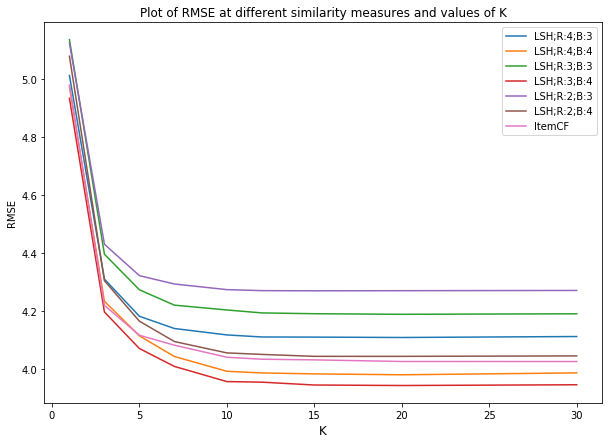

In [43]:
plt.figure(figsize=(10,7))
for val in set(test['Describe'].values):
    sv = plt.plot(test1[test1['Describe']==val]['K'],test1[test1['Describe']==val]['RMSE'])
plt.xlabel('K', fontsize=12)
plt.ylabel('RMSE')
plt.title('Plot of RMSE at different similarity measures and values of K')
plt.legend(test2['Describe'].values, loc='upper right',  fancybox = True)
# fig = sv.get_figure()
plt.savefig('rmse_k')
plt.show()

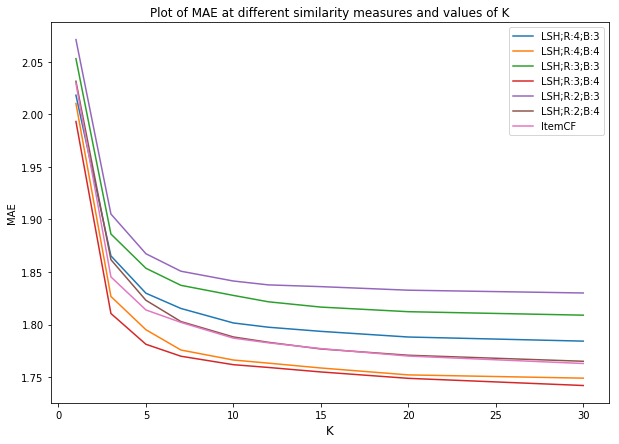

In [44]:
plt.figure(figsize=(10,7))
for val in set(test1['Describe'].values):
    plt.plot(test1[test1['Describe']==val]['K'],test1[test1['Describe']==val]['MAE'])
plt.xlabel('K', fontsize=12)
plt.ylabel('MAE')
plt.title('Plot of MAE at different similarity measures and values of K')
plt.legend(test2['Describe'].values, loc='upper right',  fancybox = True)
plt.savefig('mae_k')
plt.show()

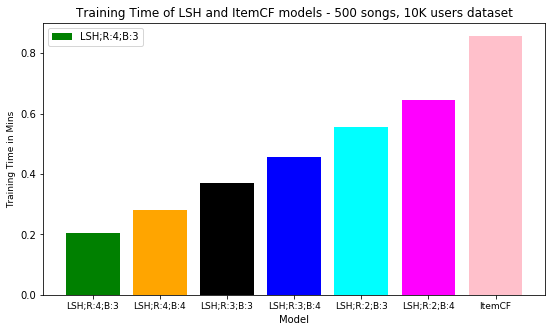

In [50]:
plt.figure(figsize=(9,5))
index = np.arange(len(test2['Describe'].values))
plt.bar(index,test2['Time'].values/60,color=['green', 'orange', 'black', 'blue', 'cyan', 'magenta','pink','yellow','red'])
plt.xlabel('Model')
plt.ylabel('Training Time in Mins',fontsize=9)
plt.xticks(index,test2['Describe'].values,fontsize=9)
plt.title('Training Time of LSH and ItemCF models - 500 songs, 10K users dataset')
plt.legend(test2['Describe'].values, loc="upper left")
plt.savefig('times')
plt.show()

### Comparing the prediction with actual listens

In [241]:
song_info = pd.read_csv('/home/pv70249/LSH_DataSets/song_info.csv')[['song_id', 'artist_name', 'track_name']]

In [275]:
lsh_sim_song_matrix_24, time_diff_mat_creation_24 = create_similarity_matrix(data,2,5)

In [251]:
icf_sim_song_matrix, time_diff_mat_creation = create_icf_similarity_matrix(data)

In [252]:
def listen(row):
    if row[['listen_count']].isnull().any():
        return 'N'
    else :
        return 'Y'

def user_prediction(sim_song_matrix,K,N):
    # Outputs
    # pred_out - Predictions including listened songs
    # pred_out_listened - Predictions excluding listened songs
    # listened - only listened songs ordered by listen count
    
    #This is for included listened songs also in prediction
    u_df_pred, u_df_listened, u_top_recommendation,  u_top_listened = predict_user_topNsongs(data,
                                                         '6a944bfe30ae8d6b873139e8305ae131f1607d5f',
                                                          sim_song_matrix, K, N, users_dict, songs_dict,
                                                          baseline, True )
    u_pred = pd.merge(u_df_pred[['song_id', 'pred']], song_info, how='inner', on='song_id').reset_index(drop=True)
    u_pred_out = pd.merge(u_pred,u_df_listened[['song_id','listen_count']],how ='left',on='song_id').reset_index(drop=True)
    u_pred_out['listened'] = u_pred_out.apply(lambda row: listen(row),axis=1)
    
    
    #This is for only non-listened songs
    df_pred1, df_listened1, top_recommendation1,  top_listened1 = predict_user_topNsongs(data,
                                                         '6a944bfe30ae8d6b873139e8305ae131f1607d5f',
                                                          sim_song_matrix, K, N, users_dict, songs_dict,
                                                          baseline, False )
    
    pred1 = pd.merge(df_pred1[['song_id', 'pred']], song_info, how='inner', on='song_id').reset_index(drop=True)
    pred_out1 = pd.merge(pred1,df_listened1[['song_id','listen_count']],how ='left',on='song_id').reset_index(drop=True)
    pred_out1['listened'] = pred_out1.apply(lambda row: listen(row),axis=1)
    
    listened = pd.merge(u_df_listened[['song_id', 'listen_count', 'pred']], song_info, how='inner', on='song_id').reset_index(drop=True)
    listened = listened.sort_values('listen_count',ascending = False)
    
    return u_pred_out,pred_out1, listened

In [276]:
lsh_pred_out,lsh_pred_out_listened, lsh_listened = user_prediction(lsh_sim_song_matrix_24,20,60)
icf_pred_out,icf_pred_out_listened, icf_listened = user_prediction(icf_sim_song_matrix,20,60)

In [277]:
lsh_pred_out[:20]

,song_id,pred,artist_name,track_name,listen_count,listened
0,SOVDSJC12A58A7A271,32.458321,Sam Cooke,Ain't Misbehavin,8.0,Y
1,SOAUWYT12A81C206F1,22.546470,Björk,Undo,78.0,Y
2,SOBONKR12A58A7A7E0,22.215872,Dwight Yoakam,You're The One,271.0,Y
3,SOOWPBJ12A8C137FB4,17.480303,Coldplay,Lost!,42.0,Y
4,SOHALKJ12AB017FCC2,15.392958,Godsmack,Speak,NaN,N
5,SOHXBXX12B34F2609B,15.105625,Irene Cara,What A Feeling,NaN,N
6,SOTYLCV12A8C143772,14.937440,Hot Chip,Bad Luck,NaN,N
7,SOUFTBI12AB0183F65,14.457492,Tub Ring,Invalid,7.0,Y
8,SONQCXC12A6D4F6A37,13.564087,Sheena Easton,Strut (1993 Digital Remaster),NaN,N
9,SOUNJIO12AB0181339,13.363443,Future Rock,Gears,NaN,N


In [283]:
lsh_pred_out_listened[:20]

,song_id,pred,artist_name,track_name,listen_count,listened
0,SOHALKJ12AB017FCC2,15.392958,Godsmack,Speak,NaN,N
1,SOHXBXX12B34F2609B,15.105625,Irene Cara,What A Feeling,NaN,N
2,SOTYLCV12A8C143772,14.937440,Hot Chip,Bad Luck,NaN,N
3,SONQCXC12A6D4F6A37,13.564087,Sheena Easton,Strut (1993 Digital Remaster),NaN,N
4,SOUNJIO12AB0181339,13.363443,Future Rock,Gears,NaN,N
5,SORJICW12A8C13640D,13.345602,Pavement,Mercy:The Laundromat,NaN,N
6,SOLWZVR12AB01849C6,13.166677,OneRepublic,All The Right Moves,NaN,N
7,SOSXLTC12AF72A7F54,12.818095,Kings Of Leon,Revelry,NaN,N
8,SOADJQJ12A8C141D38,12.351171,Beyoncé,Halo,NaN,N
9,SOPTLQL12AB018D56F,12.320539,Travie McCoy,Billionaire [feat. Bruno Mars] (Explicit Albu...,NaN,N


In [279]:
lsh_listened[:20]

,song_id,listen_count,pred,artist_name,track_name
2,SOBONKR12A58A7A7E0,271.0,22.215872,Dwight Yoakam,You're The One
1,SOAUWYT12A81C206F1,78.0,22.546470,Björk,Undo
3,SOOWPBJ12A8C137FB4,42.0,17.480303,Coldplay,Lost!
23,SONYKOW12AB01849C9,35.0,11.064311,OneRepublic,Secrets
21,SOUVTSM12AC468F6A7,32.0,11.256190,Lil Wayne / Eminem,Drop The World
28,SOFGJCW12AF72A812D,31.0,9.846413,Kelly Clarkson,Already Gone
83,SOWPASM12A8C142B88,19.0,4.054703,The Pussycat Dolls,When I Grow Up
42,SOKUPAO12AB018D576,19.0,7.846884,Paramore,The Only Exception (Album Version)
61,SOXQROF12AB0186B1D,17.0,5.549602,Lily Allen,The Fear
16,SOANQFY12AB0183239,17.0,12.060994,Muse,Uprising


In [284]:
icf_pred_out[:20]

,song_id,pred,artist_name,track_name,listen_count,listened
0,SOVDSJC12A58A7A271,32.458321,Sam Cooke,Ain't Misbehavin,8.0,Y
1,SOAUWYT12A81C206F1,22.546470,Björk,Undo,78.0,Y
2,SOBONKR12A58A7A7E0,22.545506,Dwight Yoakam,You're The One,271.0,Y
3,SOOWPBJ12A8C137FB4,17.454560,Coldplay,Lost!,42.0,Y
4,SOHALKJ12AB017FCC2,15.223569,Godsmack,Speak,NaN,N
5,SOHXBXX12B34F2609B,15.068007,Irene Cara,What A Feeling,NaN,N
6,SOUFTBI12AB0183F65,14.457492,Tub Ring,Invalid,7.0,Y
7,SONQCXC12A6D4F6A37,13.564087,Sheena Easton,Strut (1993 Digital Remaster),NaN,N
8,SORJICW12A8C13640D,13.345602,Pavement,Mercy:The Laundromat,NaN,N
9,SOEGIYH12A6D4FC0E3,13.311723,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,8.0,Y


In [285]:
icf_pred_out_listened[:20]

,song_id,pred,artist_name,track_name,listen_count,listened
0,SOHALKJ12AB017FCC2,15.223569,Godsmack,Speak,NaN,N
1,SOHXBXX12B34F2609B,15.068007,Irene Cara,What A Feeling,NaN,N
2,SONQCXC12A6D4F6A37,13.564087,Sheena Easton,Strut (1993 Digital Remaster),NaN,N
3,SORJICW12A8C13640D,13.345602,Pavement,Mercy:The Laundromat,NaN,N
4,SOLWZVR12AB01849C6,13.166677,OneRepublic,All The Right Moves,NaN,N
5,SOSXLTC12AF72A7F54,12.769214,Kings Of Leon,Revelry,NaN,N
6,SOGPBAW12A6D4F9F22,12.690291,Bon Jovi,Livin' On A Prayer,NaN,N
7,SOUNJIO12AB0181339,12.625603,Future Rock,Gears,NaN,N
8,SOADJQJ12A8C141D38,12.435297,Beyoncé,Halo,NaN,N
9,SOPTLQL12AB018D56F,12.249793,Travie McCoy,Billionaire [feat. Bruno Mars] (Explicit Albu...,NaN,N


In [282]:
icf_listened[:20]

,song_id,listen_count,pred,artist_name,track_name
2,SOBONKR12A58A7A7E0,271.0,22.545506,Dwight Yoakam,You're The One
1,SOAUWYT12A81C206F1,78.0,22.546470,Björk,Undo
3,SOOWPBJ12A8C137FB4,42.0,17.454560,Coldplay,Lost!
22,SONYKOW12AB01849C9,35.0,11.055228,OneRepublic,Secrets
21,SOUVTSM12AC468F6A7,32.0,11.345303,Lil Wayne / Eminem,Drop The World
28,SOFGJCW12AF72A812D,31.0,10.583965,Kelly Clarkson,Already Gone
80,SOWPASM12A8C142B88,19.0,4.054703,The Pussycat Dolls,When I Grow Up
43,SOKUPAO12AB018D576,19.0,7.997503,Paramore,The Only Exception (Album Version)
49,SOXQROF12AB0186B1D,17.0,7.080490,Lily Allen,The Fear
17,SOANQFY12AB0183239,17.0,11.915934,Muse,Uprising


### Baseline Metrics Calculation

In [289]:
def baseline_metrics(baseline, data_set):
    act = []
    pre = []
    act = data_set['listen_count']
    for i in range(len(act)):
        pre.append(baseline)
    
    b_rmse = rmse(np.array(act),np.array(pre))
    b_mae = mae(np.array(act),np.array(pre))
    b_mse = mse(np.array(act),np.array(pre))
    
    return b_rmse, b_mae, b_mse

b_rmse, b_mae, b_mse = baseline_metrics(baseline,test_set)

print (b_rmse, b_mae, b_mse)

4.303718310774218 2.0061263711521926 18.52199129849329
